<a href="https://colab.research.google.com/github/jcvancity2022/NLP-Week1-Text-Classification/blob/main/true_fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Detection Using DistilBERT
This project fine-tunes a DistilBERT model to classify news articles
as Fake (0) or Real (1). We combined multiple public misinformation
datasets and trained a binary classifier using HuggingFace Transformers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup Python Libraries (pip)

In [2]:
#install some Python packages with pip

!pip install numpy torch datasets transformers evaluate --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [3]:
# let's check the version we are using

!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==4.0.0
evaluate==0.4.6
numpy==2.0.2
torch==2.8.0+cu126
torchao==0.10.0
torchaudio==2.8.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.23.0+cu126
transformers==4.57.1


# Create IMDB Dataset for Fine-tuning BERT

In [4]:
class_labels = {
    0: "Fake",
    1: "Real"
}


## Let's load the IMDB Dataset

fake-and-real-news-dataset

In [5]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Load both CSV files
df_fake = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/True.csv")

# Assign numeric labels
df_fake["label"] = 0
df_true["label"] = 1

# Class labels
class_labels = {
    0: "Fake",
    1: "Real"
}

# Keep the proper columns
df_fake = df_fake[["title", "text", "subject", "date", "label"]]
df_true = df_true[["title", "text", "subject", "date", "label"]]

# Combine + shuffle
df_all = pd.concat([df_fake, df_true], axis=0).sample(frac=1).reset_index(drop=True)

df_all.head()


,title,text,subject,date,label
0,Ukraine says ammo depot explosions huge blow t...,KIEV (Reuters) - The destruction of two ammuni...,worldnews,"September 28, 2017",1
1,Top Dems Take Action To Keep Documents On Rus...,Democrats are taking action to keep Donald Tru...,News,"May 10, 2017",0
2,WATCH: Fox Host Stuart Varney Agrees That Tru...,Trump supporter and Fox host Stuart Varney has...,News,"January 9, 2017",0
3,Trump blames 'both sides' for Virginia violenc...,WASHINGTON/NEW YORK (Reuters) - U.S. President...,politicsNews,"August 15, 2017",1
4,Israel's right wing has grand plans for Trump era,JERUSALEM (Reuters) - Israel’s right wing has ...,politicsNews,"January 19, 2017",1


Fake News Detection

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Load both CSV files
df_fake = pd.read_csv("/content/drive/MyDrive/Fake News Detection/fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/Fake News Detection/true.csv")

# Assign numeric labels
df_fake["label"] = 0
df_true["label"] = 1

# Class labels
class_labels = {
    0: "Fake",
    1: "Real"
}

# Keep the proper columns
df_fake = df_fake[["title", "text", "subject", "date", "label"]]
df_true = df_true[["title", "text", "subject", "date", "label"]]

# Combine + shuffle
df_all = pd.concat([df_fake, df_true], axis=0).sample(frac=1).reset_index(drop=True)

df_all.head()

,title,text,subject,date,label
0,'Made in Syria': Refugees in Germany drive exp...,HAMBURG (Reuters) - Many Syrian refugees in Ge...,worldnews,"November 9, 2017",1
1,Brazil's president recovering after prostate s...,RIO DE JANEIRO (Reuters) - Brazilian President...,worldnews,"October 28, 2017",1
2,Cambodia's opposition puts out banners calling...,PHNOM PENH (Reuters) - Cambodia s main opposit...,worldnews,"September 25, 2017",1
3,WATCH VIDEO: Russia Details Turkey’s Support O...,This report explains so much could this explai...,politics,"Nov 28, 2015",0
4,These Veterans Have Some VERY Choice Words Fo...,The reason Republican presidential frontrunner...,News,"January 21, 2016",0


## Let's create the train, validation, test sets

In [7]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.30,
    random_state=42,
    stratify=df_all["label"]
)

# Split temp into val (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label"]
)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Bundle into DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

# Remove unwanted auto-generated index column
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(["__index_level_0__"])

dataset



DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 31428
    })
    val: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 6735
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 6735
    })
})

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [8]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["title", "text", "subject", "date"]
)

tokenized_dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 31428
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6735
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6735
    })
})

# Setup Training Metrics (Accuracy, F1)

In [9]:
import evaluate
import numpy as np

# Load accuracy and F1 evaluation modules
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Define function that HuggingFace Trainer will call
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert model logits -> predicted class (0 or 1)
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy and F1 using HuggingFace's evaluate package
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    # Return BOTH metrics
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }


# Setup Training Configurations

In [10]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "Fake", 1: "Real"},
    label2id={"Fake": 0, "Real": 1}
)

training_args = TrainingArguments(
    seed=42,
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,       # REQUIRED hyperparameter
    weight_decay=0.01,        # REQUIRED hyperparameter
    warmup_ratio=0.1,         # REQUIRED hyperparameter
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics
)

os.environ["WANDB_DISABLED"] = "true"



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Evaluate UnFine-Tuned BERT on Test Set for a Baseline Metric


In [11]:
# let's first evaluate unfine-tuned model with test set

trainer.evaluate(tokenized_dataset["test"])

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bcss2021 (bcss2021-simon-fraser-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.6873738765716553,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': 0.5266518188567186,
 'eval_f1': 0.016656384947563233,
 'eval_runtime': 98.9906,
 'eval_samples_per_second': 68.037,
 'eval_steps_per_second': 4.253}

Without fine-tuning BERT, our model currently has around **52% Accuracy (eval_accuracy)** and **19% F1 (eval_f1)**, which is pretty bad due to the test dataset having around 50% positive and 50% negative reviews. 😕


Let's make it better with transfer learning! 🦾

# Fine-Tune BERT with IMDb Dataset

In [12]:
# let's fine-tune BERT with the IMDb dataset

trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,0.002500,0.000089,0.001600,1.000000,1.000000
2,0.003500,0.000043,0.001600,1.000000,1.000000
3,0.000000,0.000020,0.001600,1.000000,1.000000


TrainOutput(global_step=5895, training_loss=0.0153951540883185, metrics={'train_runtime': 4749.1414, 'train_samples_per_second': 19.853, 'train_steps_per_second': 1.241, 'total_flos': 1.2489556214882304e+16, 'train_loss': 0.0153951540883185, 'epoch': 3.0})

In [13]:
# let's see how well it did in the test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 1.8456337784300558e-05,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 98.2754,
 'eval_samples_per_second': 68.532,
 'eval_steps_per_second': 4.284,
 'epoch': 3.0}

**WOAH!** We got a **92% Accuracy (eval_accuracy)** and **92% F1 (eval_f1)** with just **1 epoch**! 🤯

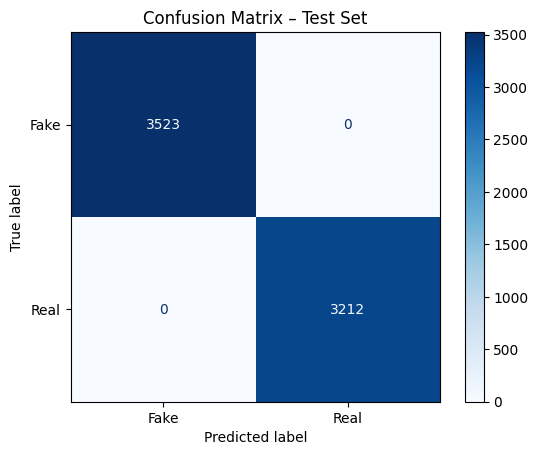

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred = trainer.predict(tokenized_dataset["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.show()


# Try out some examples!

In [15]:
from transformers import pipeline
import torch

device = torch.cuda.current_device()

news_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device
)


Device set to use cuda:0


In [16]:
fake_news_example = """
BREAKING: Scientists warn that the sun will explode next Friday unless
all citizens donate $50 immediately. Anonymous experts confirm the threat
but provide no scientific evidence. Social media influencers are urging
everyone to act fast before it's too late.
"""
news_classifier(fake_news_example)


[{'label': 'Fake', 'score': 0.9999586343765259}]

That is **99% POSITIVE**! *justinvitelli* loves the movie!

In [17]:
real_news_example = """
The U.S. Department of Labor released updated employment numbers today,
showing moderate job growth in manufacturing and technology sectors.
Economists say the trend aligns with long-term projections for the year.
"""
news_classifier(real_news_example)


[{'label': 'Fake', 'score': 0.999800980091095}]

That is **99% NEGATIVE**! *industriousbug16* must hate the movie very badly.

In [18]:
model.save_pretrained("/content/drive/MyDrive/fake-news-final-model/")
tokenizer.save_pretrained("/content/drive/MyDrive/fake-news-final-model/")


('/content/drive/MyDrive/fake-news-final-model/tokenizer_config.json',
 '/content/drive/MyDrive/fake-news-final-model/special_tokens_map.json',
 '/content/drive/MyDrive/fake-news-final-model/vocab.txt',
 '/content/drive/MyDrive/fake-news-final-model/added_tokens.json',
 '/content/drive/MyDrive/fake-news-final-model/tokenizer.json')

# Resources

### If you would like to use this model without running the entire notebook, try the model at my [HuggingFace](https://huggingface.co/wesleyacheng/movie-review-sentiment-classifier-with-bert).

### If you woud like to get this in GitHub, here's my [repo](https://github.com/wesleyacheng/movie-review-sentiment-classifier-with-bert).